In [10]:
from os.path import join

import cv2
import matplotlib.pyplot as plt

import torch

from dataloader import get_noisy_image, train_transformation
from model import build_model

from skimage.metrics import peak_signal_noise_ratio as PSNR

In [2]:
# model = Unet(in_channels=3, out_channels=3, depth=3)
model_type = "denoising"
# model = build_model(model_type=model_type)

In [3]:
from transformers import SwinForMaskedImageModeling
model = SwinForMaskedImageModeling.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinForMaskedImageModeling: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinForMaskedImageModeling from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinForMaskedImageModeling from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SwinForMaskedImageModeling were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized: ['decoder.0.weight', 'swin.embeddings.mask_token', 'decoder.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

In [4]:
path = "results/"

In [5]:
model

SwinForMaskedImageModeling(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [6]:
model.load_state_dict(torch.load(join("results/model_regression.pth")))
model.eval()

SwinForMaskedImageModeling(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [11]:
def transformations():
    """Applies transformations to an image.

    Args:
        image: image, np.array
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.ConvertImageDtype(torch.float),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=(0, ),
                             std=(1, )),
    ])
    return transform

In [12]:
dataset_path = "/Users/irina/Documents/Etudes/DS/datasets/GAN/monet_style_dataset/All/"
test_path = join(dataset_path, "train/")

transform = transformations()

image = cv2.imread(join(test_path, "images/image1.png"))
image= transform(image).unsqueeze(0)
image = image
noisy_image = get_noisy_image(image)
preds = model(noisy_image).logits
target = torch.clone(image)

In [13]:
def imshow(pred, target, noisy_img, ax=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(20,20))
    pred = pred.numpy().transpose((1, 2, 0))
    noisy_img = noisy_img.numpy().transpose((1, 2, 0))
    target = target.numpy().transpose((1, 2, 0))

    psnr_noisy = PSNR(target, noisy_img)
    psnr_pred = PSNR(target, pred)

    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    ax[0].imshow(target)
    ax[0].set_title("Original image")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].tick_params(axis='both', length=0)
    ax[0].set_xticklabels('')
    ax[0].set_yticklabels('')

    ax[1].imshow(noisy_img)
    ax[1].set_title("Noisy image")
    ax[1].set_xlabel(f'PSNR : {psnr_noisy:.02f}')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].tick_params(axis='both', length=0)
    ax[1].set_xticklabels('')
    ax[1].set_yticklabels('')

    ax[2].imshow(pred)
    ax[2].set_title("Predicted image")
    ax[2].set_xlabel(f'PSNR : {psnr_pred:.02f}')
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].spines['bottom'].set_visible(False)
    ax[2].tick_params(axis='both', length=0)
    ax[2].set_xticklabels('')
    ax[2].set_yticklabels('')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


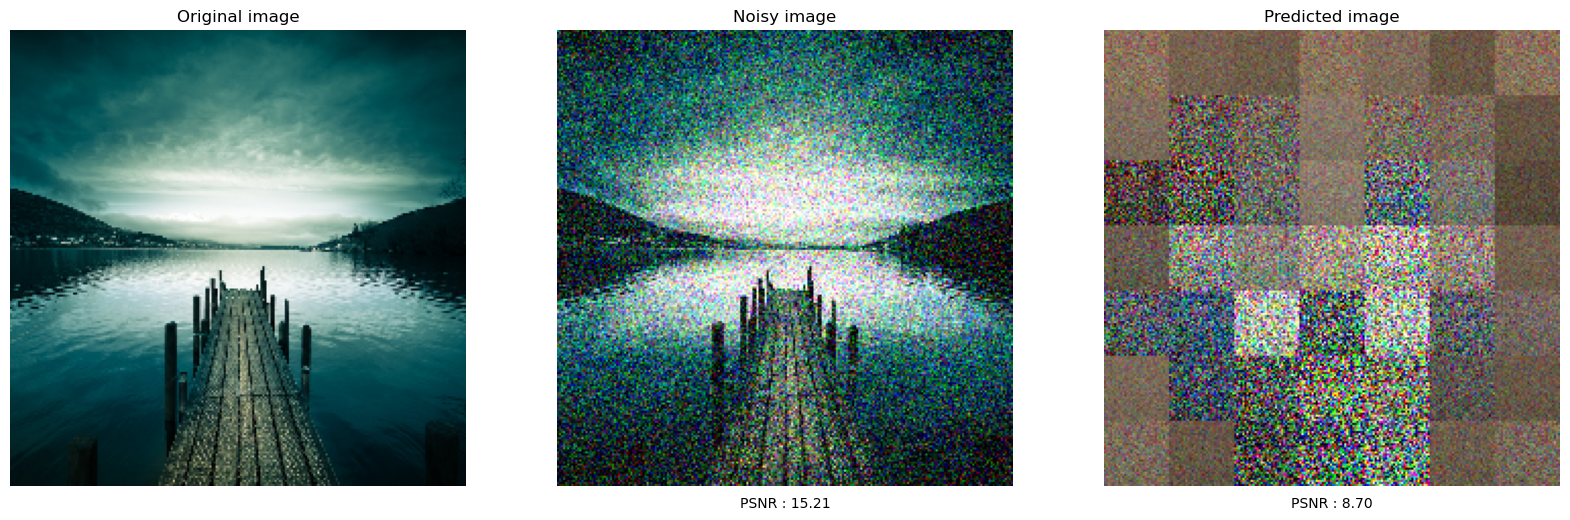

In [14]:
imshow(preds[0].detach(), target[0].detach(), noisy_image[0].detach())

In [1]:
from os.path import join

import numpy as np
from PIL import Image

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from dataloader import get_noisy_image, test_transformation
from model import build_model

from skimage.metrics import peak_signal_noise_ratio as PSNR

/Users/irina/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/irina/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/irina/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <11CA4EBF-5A84-3662-A35A-A039CEE97F5E> /Users/irina/miniconda3/envs/ml/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [3]:
def imshow(pred, target, noisy_img, ax=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(20,20))
    pred = pred.numpy().transpose((1, 2, 0))
    noisy_img = noisy_img.numpy().transpose((1, 2, 0))
    target = target.numpy().transpose((1, 2, 0))

    psnr_noisy = PSNR(target, noisy_img)
    psnr_pred = PSNR(target, pred)

    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    ax[0].imshow(target)
    ax[0].set_title("Original image")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].tick_params(axis='both', length=0)
    ax[0].set_xticklabels('')
    ax[0].set_yticklabels('')

    ax[1].imshow(noisy_img)
    ax[1].set_title("Noisy image")
    ax[1].set_xlabel(f'PSNR : {psnr_noisy:.02f}')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].tick_params(axis='both', length=0)
    ax[1].set_xticklabels('')
    ax[1].set_yticklabels('')

    ax[2].imshow(pred)
    ax[2].set_title("Predicted image")
    ax[2].set_xlabel(f'PSNR : {psnr_pred:.02f}')
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].spines['bottom'].set_visible(False)
    ax[2].tick_params(axis='both', length=0)
    ax[2].set_xticklabels('')
    ax[2].set_yticklabels('')

In [4]:
model_name = "tiny"
model_type = "regression"

model = build_model(model_name=model_name, model_type=model_type, dim=3)

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinForMaskedImageModeling: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinForMaskedImageModeling from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinForMaskedImageModeling from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SwinForMaskedImageModeling were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized: ['swin.embeddings.mask_token', 'decoder.0.weight', 'decoder.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

In [5]:
path = "results/"

In [6]:
model.load_state_dict(torch.load(join(path, f"model_{model_type}.pth")))
model.eval()

SwinForMaskedImageModeling(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [7]:
import torchvision.transforms as transforms


def transformation(img_size):
    """Applies transformations to an image.

    Args:
        image: image, np.array
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return transform

In [8]:
dataset_path = "/Users/irina/Documents/Etudes/DS/datasets/GAN/monet_style_dataset/All/test/"

transform = transformation(224)

image = cv2.imread(join(dataset_path, "images/image24.png"))
# target = Image.open(join(dataset_path, "masks/image24.png")).convert("RGB")
processed_image = transform(image).unsqueeze(0)
noisy_image = get_noisy_image(processed_image)

In [9]:
noisy_image.shape

torch.Size([1, 3, 224, 224])

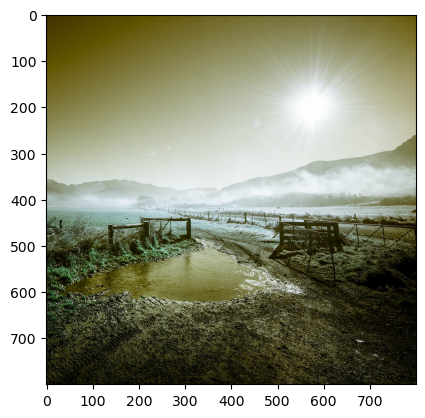

In [10]:
plt.imshow(image)
plt.show()

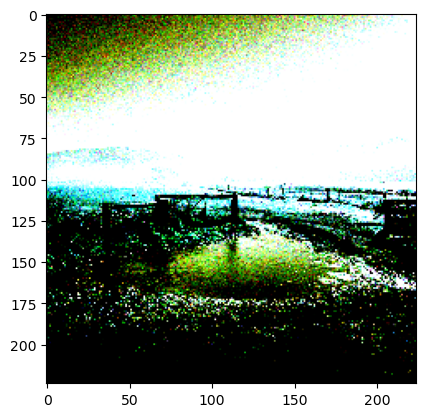

In [11]:
plt.imshow(noisy_image[0].numpy().transpose(1, 2, 0))
plt.show()

In [13]:
preds = model(processed_image).logits
mask = processed_image[0]

In [14]:
mask.shape

torch.Size([3, 224, 224])

In [15]:
mask.clip(0,1)

tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

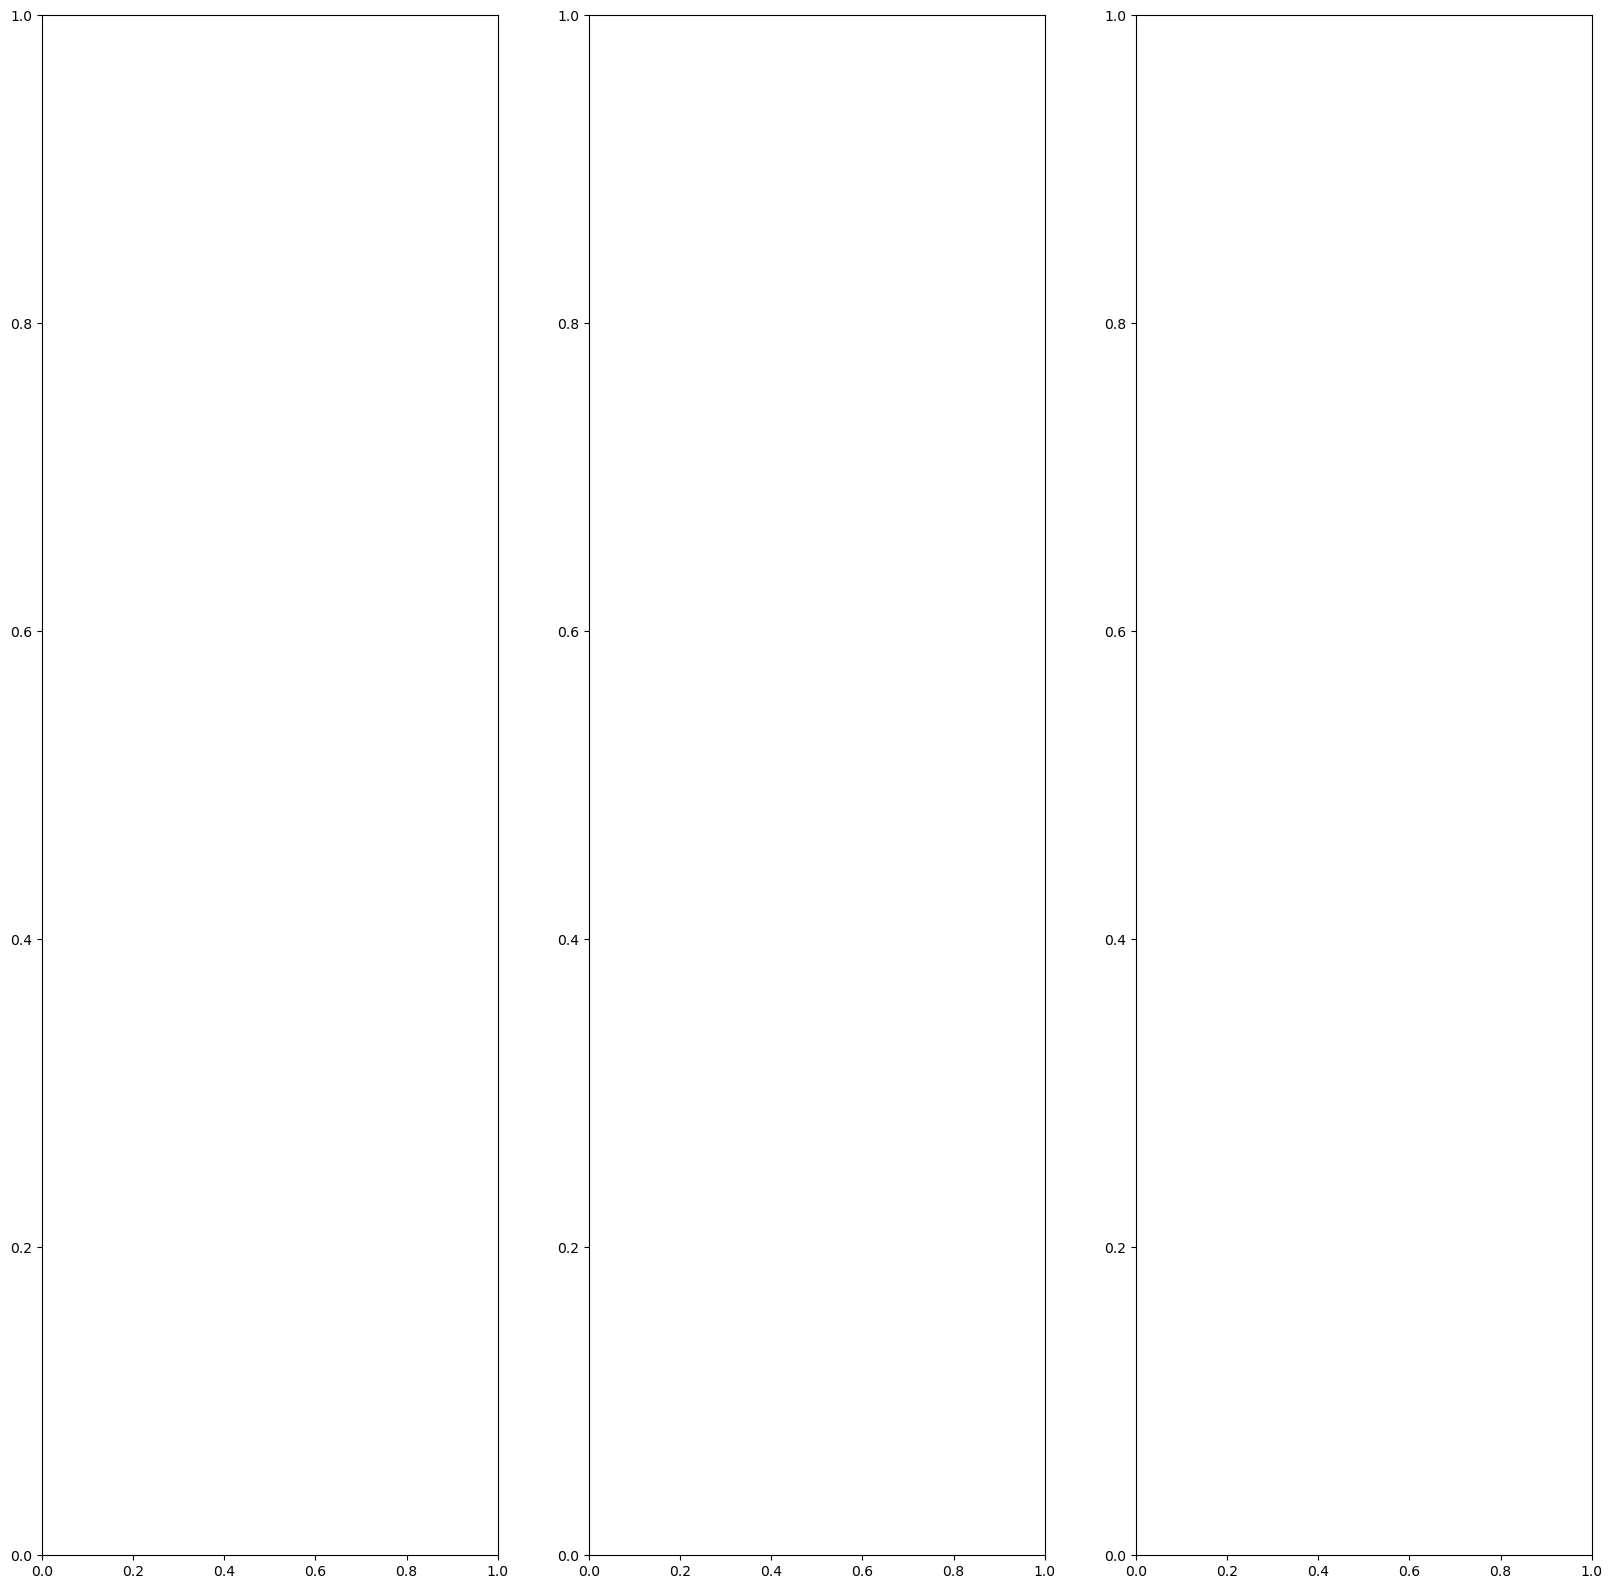

In [16]:
imshow(preds, mask.clip(0,1), noisy_image[0])

In [196]:
model.model

SwinModel(
  (embeddings): SwinEmbeddings(
    (patch_embeddings): SwinPatchEmbeddings(
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): SwinEncoder(
    (layers): ModuleList(
      (0): SwinStage(
        (blocks): ModuleList(
          (0): SwinLayer(
            (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attention): SwinAttention(
              (self): SwinSelfAttention(
                (query): Linear(in_features=96, out_features=96, bias=True)
                (key): Linear(in_features=96, out_features=96, bias=True)
                (value): Linear(in_features=96, out_features=96, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): SwinSelfOutput(
                (dense): Linear(in_features=96, out_features=96, bias=True)
            

In [197]:
for param in model.model.parameters():
    # param.requires_grad = False
    print(param)

Parameter containing:
tensor([[[[ 2.6287e-02,  5.4684e-02, -2.7449e-02, -2.4759e-02],
          [ 6.1410e-02,  6.4180e-02,  1.5827e-02,  1.5706e-02],
          [ 9.2950e-03,  2.0998e-02, -9.9900e-03, -2.8406e-02],
          [-8.1178e-02, -4.8468e-02, -4.3369e-02, -3.4513e-02]],

         [[ 1.4919e-02,  2.6804e-02, -2.7253e-02, -3.2034e-02],
          [ 4.6301e-02,  7.4146e-02,  3.2031e-02,  3.9782e-02],
          [-2.3699e-02,  2.6028e-02,  3.9829e-02, -9.0361e-03],
          [-5.8936e-02,  2.3629e-03,  2.8448e-02,  1.3387e-02]],

         [[-6.0582e-02, -1.2645e-02, -5.5375e-02, -5.7517e-02],
          [-8.5470e-03,  3.7889e-02,  9.4947e-03,  2.5601e-02],
          [-1.1952e-02, -7.5405e-03, -8.4367e-04,  4.5388e-02],
          [-1.9699e-02, -1.2455e-02,  1.8031e-02,  1.0921e-01]]],


        [[[ 3.1131e-03,  7.7620e-03,  8.4918e-03,  1.7820e-04],
          [ 8.0052e-03,  7.5858e-03,  8.3196e-03,  4.4968e-03],
          [ 7.3892e-03,  6.8404e-03,  5.7544e-03,  2.9808e-03],
          

In [4]:
from transformers import AutoImageProcessor, Swinv2ForMaskedImageModeling
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = Swinv2ForMaskedImageModeling.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

num_patches = (model.config.image_size // model.config.patch_size) ** 2
pixel_values = image_processor(images=image, return_tensors="pt").pixel_values
# create random boolean mask of shape (batch_size, num_patches)
bool_masked_pos = torch.randint(low=0, high=2, size=(1, num_patches)).bool()

outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
loss, reconstructed_pixel_values = outputs.loss, outputs.logits
list(reconstructed_pixel_values.shape)

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
You are using a model of type swin to instantiate a model of type swinv2. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing Swinv2ForMaskedImageModeling: ['swin.encoder.layers.0.blocks.0.output.dense.weight', 'swin.encoder.layers.2.blocks.0.layernorm_after.weight', 'swin.encoder.layers.0.blocks.1.layernorm_before.bias', 'swin.encoder.layers.2.blocks.3.attention.self.value.weight', 'swin.encoder.layers.2.blocks.0.attention.self.query.weight', 'swin.encoder.layers.2.blocks.4.attention.self.query.bias', 'swin.encoder.layers.2.blocks.2.attention.self.value.bias', 'swin.encoder.layers.1.blocks.1.output.dense.weight', 'swin.encoder.layers.1.blocks.0.attention.output.dense.bias', 'swin.en

[1, 3, 224, 224]

In [5]:
model

Swinv2ForMaskedImageModeling(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias

In [16]:
print(model)

Swinv2ForMaskedImageModeling(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias

In [25]:
x = torch.randn((1, 3, 224, 224))

outputs = model.swinv2(x)

In [26]:
print(outputs.last_hidden_state.shape)

torch.Size([1, 49, 768])


In [81]:
dataset_path = "data/"

transform = test_transformation(224)

image = cv2.imread(join(dataset_path, "DSC00213.jpg"))
image= transform(image).unsqueeze(0)
image = image
noisy_image = get_noisy_image(image)
preds = model(noisy_image)
target = torch.clone(image)

TypeError: Unexpected type <class 'numpy.ndarray'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


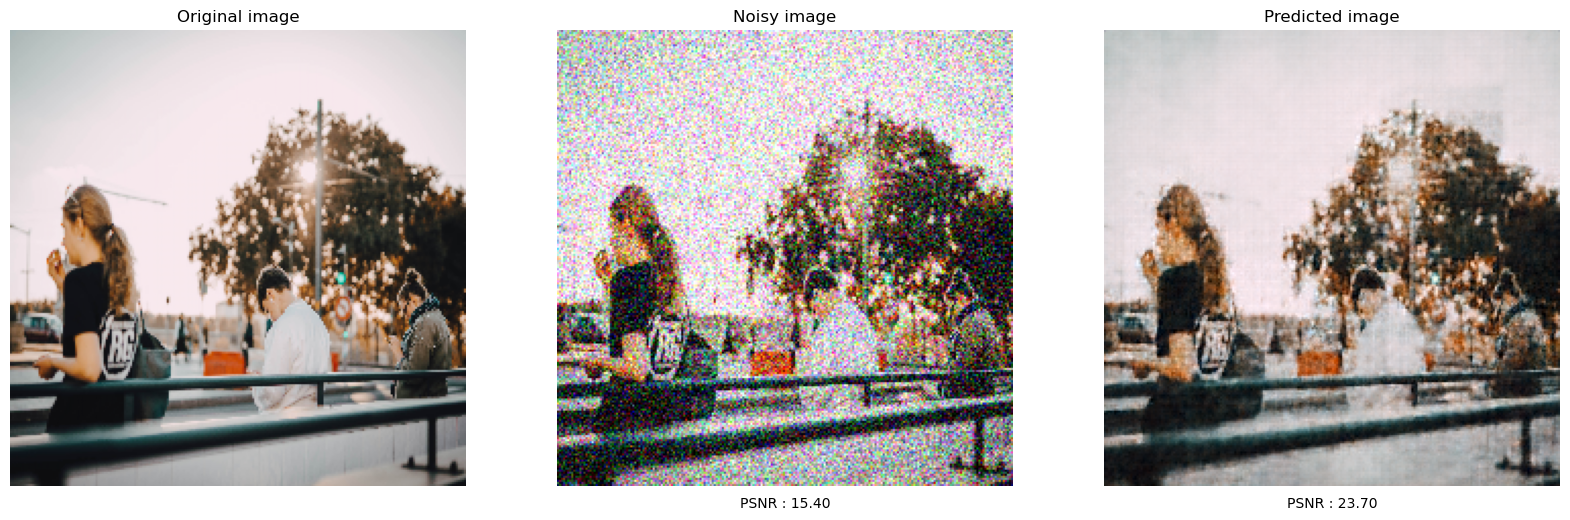

In [8]:
imshow(preds[0].detach(), target[0].detach(), noisy_image[0].detach())

In [59]:
def imshow(original, target, pred, ax=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(20,20))
    original = original.numpy().transpose((1, 2, 0))
    target = target.numpy().transpose((1, 2, 0))
    pred = pred.numpy().transpose((1, 2, 0))

    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    print(original.max())

    ax[0].imshow(original)
    ax[0].set_title("Original image")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].tick_params(axis='both', length=0)
    ax[0].set_xticklabels('')
    ax[0].set_yticklabels('')

    ax[1].imshow(target)
    ax[1].set_title("Target image")
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].tick_params(axis='both', length=0)
    ax[1].set_xticklabels('')
    ax[1].set_yticklabels('')

    ax[2].imshow(pred)
    ax[2].set_title("Predicted image")
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].spines['bottom'].set_visible(False)
    ax[2].tick_params(axis='both', length=0)
    ax[2].set_xticklabels('')
    ax[2].set_yticklabels('')